In [57]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import yaml                                                                     #for reading running parameters from external yaml file (Euler)
import argparse

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from sklearn import svm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import normalize, to_categorical
import talos

In [45]:
considered_n_predictions = 20
activation_image_prediction = False
considered_n_classes = 0
considered_n_probabilities = 20
activation_train_test_data = False
model_type = 'neural'                                                           #either 'neural' or 'svm'
activation_hack_train_data = False

In [21]:
def predict_image_data(number_pictures):
    model = VGG16()
    M_prediction_classes = []
    M_prediction_probabilities = []
    index_image = []
    for i in range(number_pictures):
        image_number = str(i)
        image_number = image_number.zfill(5)
        index_image.append(image_number)                                        #append number of image name for prediction file

        image = load_img('./handout/food/' + image_number + '.jpg', target_size=(224, 224))  #min number = 00000, max number = 09999
        print(image_number, '.jpg')
        image = img_to_array(image)                                             #convert the image pixels to a numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))#reshape data for the model
        image = preprocess_input(image)                                         #prepare the image for the VGG model
        yhat = model.predict(image)                                             #predict the probability across all output classes
        yhat = decode_predictions(yhat, top=1000)                               #convert the probabilities to class labels
        prediction_matrix = pd.DataFrame(data=yhat[0][:])                      #retrieve the most likely result, e.g. highest probability
        #print(probability_matrix)
        image_classes = []
        for row in prediction_matrix[0][0:considered_n_predictions]:
            numbers = row.split('n')
            image_classes.append(int(numbers[1]))
        image_probabilities = prediction_matrix[2][0:considered_n_predictions]
        M_prediction_classes.append(image_classes)
        M_prediction_probabilities.append(image_probabilities)
    M_prediction = np.c_[index_image, M_prediction_classes, M_prediction_probabilities]
    M_prediction_pd = pd.DataFrame(data=M_prediction, columns=["image_name", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7", "class_8", "class_9", "class_10", "class_11", "clas_12", "class_13", "class_14", "class_15", "class_16", "class_17", "class_18", "class_19", "class_20", "probability_1", "probability_2", "probability_3", "probability_4", "probability_5", "probability_6", "probability_7", "probability_8", "probability_9", "probability_10", "probability_11", "probability_12", "probability_13", "probability_14", "probability_15", "probability_16", "probability_17", "probability_18", "probability_19", "probability_20"])
    print(M_prediction_pd)
    M_prediction_pd.to_csv(r'predictions_' + str(considered_n_predictions) + '.csv', index=False, float_format='%.5f')

    return

In [22]:
def read_class_data():
    #load predictions
    predictions = pd.read_csv('predictions_20.csv', delimiter=',')
    image_number = predictions.iloc[:,0]
    image_number = image_number.map(lambda x: f'{x:0>5}')                       #append zeros in the front
    image_class = predictions.iloc[:,1:(considered_n_predictions+1)]
    image_probabilities = predictions.iloc[:,(considered_n_predictions+1):(2*considered_n_predictions+1)]

    #load train data
    train_triplets_plain = pd.read_csv('./handout/train_triplets.txt', delimiter=' ', header=None)
    if activation_hack_train_data:
        hack_train_triplets = pd.read_csv('./handout/hack_train_triplets.txt', delimiter=',', header=None)
        train_triplets = pd.concat([train_triplets_plain, hack_train_triplets]).reset_index(drop=True)
    else:
        train_triplets = train_triplets_plain

    #load test data
    test_triplets = pd.read_csv('./handout/test_triplets.txt', delimiter=' ', header=None)

    return image_number, image_class, image_probabilities, train_triplets, test_triplets

In [23]:
def create_class_array(image_class):
    class_array = []
    for i in range(len(image_class)):
        for j in range(considered_n_classes+considered_n_probabilities):
            if class_array.count(image_class.iloc[i,j])==0:
                class_array.append(image_class.iloc[i,j])

    return class_array, len(class_array)

In [24]:
def create_data_point(triplets, i, triplets_column, image_class, image_probabilities, class_array):
    if triplets_column == 'B':
        triplets_column_second = 1
        triplets_column_third = 2
    else:
        triplets_column_second = 2
        triplets_column_third = 1
    X = np.zeros(3*len(class_array), dtype=int)

    #calculate classes and probability numbers for A, B, C
    classes_first_image = image_class.iloc[triplets[0][i],0:considered_n_classes]                               #take first 'considered_n_classes' class numbers and put them to classes_first_image
    classes_first_image = np.asarray(classes_first_image)
    classes_second_image = image_class.iloc[triplets[triplets_column_second][i],0:considered_n_classes]
    classes_second_image = np.asarray(classes_second_image)
    classes_third_image = image_class.iloc[triplets[triplets_column_third][i],0:considered_n_classes]
    classes_third_image = np.asarray(classes_third_image)

    probability_first_image = image_class.iloc[triplets[0][i],considered_n_classes:(considered_n_classes+considered_n_probabilities)]  #take the following 'considered_n_probabilities' class numbers and put them to probability_first_image
    probability_first_image = np.asarray(probability_first_image)
    probability_second_image = image_class.iloc[triplets[triplets_column_second][i],considered_n_classes:(considered_n_classes+considered_n_probabilities)]
    probability_second_image = np.asarray(probability_second_image)
    probability_third_image = image_class.iloc[triplets[triplets_column_third][i],considered_n_classes:(considered_n_classes+considered_n_probabilities)]
    probability_third_image = np.asarray(probability_third_image)

    #FOR IMAGE IN COLUMN 'A': FILL MATRIX WITH 1 FOR 'considered_n_classes' AND PROBABILITY FOR 'considered_n_probabilities'

    for j_class in range(considered_n_classes):
        index_class_first_image = class_array.index(classes_first_image[j_class])
        X[index_class_first_image] = 1
    for j_proba in range(considered_n_probabilities):
        index_proba_first_image = class_array.index(probability_first_image[j_proba])
        X = np.array(X, dtype=float)
        X[index_proba_first_image] = image_probabilities.iloc[triplets[0][i], j_proba+considered_n_classes]

    #FOR IMAGE IN COLUMN 'B' and 'C': FILL MATRIX WITH 1 FOR 'considered_n_classes' AND PROBABILITY FOR 'considered_n_probabilities'

    for k_class in range(considered_n_classes):
        index_class_second_image = class_array.index(classes_second_image[k_class])
        X[index_class_second_image + len(class_array)] = 1
    for k_proba in range(considered_n_probabilities):
        index_proba_second_image = class_array.index(probability_second_image[k_proba])
        X = np.array(X, dtype=float)
        X[index_proba_second_image + len(class_array)] = image_probabilities.iloc[triplets[triplets_column_second][i], k_proba+considered_n_classes]

    for l_class in range(considered_n_classes):
        index_class_third_image = class_array.index(classes_third_image[l_class])
        X[index_class_third_image + 2*len(class_array)] = 1
    for l_proba in range(considered_n_probabilities):
        index_proba_third_image = class_array.index(probability_third_image[l_proba])
        X = np.array(X, dtype=float)
        X[index_proba_third_image + 2*len(class_array)] = image_probabilities.iloc[triplets[triplets_column_third][i], l_proba+considered_n_classes]

    #at this point, X contains 2*considered_n_classes times a 1.0 and 2*considered_n_probabilities times a probability
    #print(X)
    #print(np.count_nonzero(X))
    return X

In [25]:
def create_train_data(train_triplets, image_class, image_probabilities, class_array):
    X_TRAIN = []
    Y_LABELS = []
    for i in range(len(train_triplets)):
    #for i in range(1):                                                          #for debugging purposes
        #print('train', i)                                                       #progress bar if the waiting takes too long:)
        X = create_data_point(train_triplets, i, 'B', image_class, image_probabilities, class_array)
        X_TRAIN.append(X)
        Y_LABELS.append(1)

        X = create_data_point(train_triplets, i, 'C', image_class, image_probabilities, class_array)
        X_TRAIN.append(X)
        Y_LABELS.append(0)
    M_TRAIN_pd = pd.DataFrame(data=X_TRAIN)
    M_LABELS_pd = pd.DataFrame(data=Y_LABELS)
    M_TRAIN_pd.to_csv(r'train_matrix.csv', index=False)
    M_LABELS_pd.to_csv(r'train_labels.csv', index=False)
    return

In [26]:
def create_test_data(test_triplets, image_class, image_probabilities, class_array):
    X_TEST = []
    for i in range(len(test_triplets)):
    #for i in range(1):                                                          #for debugging purposes
        #print('test', i)                                                        #progress bar if the waiting takes too long:)
        X = create_data_point(test_triplets, i, 'B', image_class, image_probabilities, class_array)
        X_TEST.append(X)

    M_TEST_pd = pd.DataFrame(data=X_TEST)
    M_TEST_pd.to_csv(r'test_matrix.csv', index=False)
    return

In [27]:
def read_model_data():
    X_TRAIN = pd.read_csv('train_matrix.csv', delimiter=',')
    Y_LABELS = pd.read_csv('train_labels.csv', delimiter=',')
    Y_LABELS = Y_LABELS.iloc[:,0]
    X_TEST = pd.read_csv('test_matrix.csv', delimiter=',')
    return np.asarray(X_TRAIN), np.asarray(Y_LABELS), np.asarray(X_TEST)

In [84]:
#--------------------------------MAIN-------------------------------------------
#PREDICT THE FIRST 'CONSIDERED_N_PREDICTIONS' CLASSES AND THE CORRESPONDING PROBABILITIES

if activation_image_prediction:
    number_pictures = 10000
    print('Predicting image classes and image probabilities...')
    predict_image_data(number_pictures)                                                #create file 'predictions.csv'

if activation_train_test_data:
    #read in the class data from the predictions.csv
    print('Reading class data...')
    [image_number, image_class, image_probabilities, train_triplets, test_triplets] = read_class_data()

    #create an array that contains every predicted class only once
    print('Creating class array...')
    [class_array, n_different_labels] = create_class_array(image_class)

    #CREATE TWO DATA POINTS FOR EACH ROW IN 'train_triplets.csv'
    print('Preprocessing training data...')
    create_train_data(train_triplets, image_class, image_probabilities, class_array)

    #CREATE TWO DATA POINTS FOR EACH ROW IN 'test_triplets.csv'
    print('Preprocessing testing data...')
    create_test_data(test_triplets, image_class, image_probabilities, class_array)

if model_type == 'svm':
    [X_TRAIN, Y_LABELS, X_TEST] = read_model_data()

    print('Started training svm-model...')
    prediction_model = svm.SVC(kernel='linear', probability=True)
    prediction_model.fit(X_TRAIN, Y_LABELS)
    y_doubled = prediction_model.predict_proba(X_TEST)[:,1]
elif model_type == 'neural':
    [X_TRAIN, Y_LABELS, X_TEST] = read_model_data()

    print('Started training neural network...')
    prediction_model = tf.keras.models.Sequential()
    prediction_model.add(tf.keras.layers.Flatten(input_shape=(len(X_TRAIN[0]),)))
    prediction_model.add(tf.keras.layers.Dense(128, activation='relu'))
    prediction_model.add(tf.keras.layers.BatchNormalization())
    prediction_model.add(tf.keras.layers.Dropout(0.3))
    prediction_model.add(tf.keras.layers.Dense(128, activation='relu'))
    prediction_model.add(tf.keras.layers.Dense(1, activation='relu'))
    prediction_model.summary()

    prediction_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = prediction_model.fit(X_TRAIN, Y_LABELS, epochs=100, batch_size=64, verbose=1,workers=-1,validation_split=0.1)

    y_doubled = prediction_model.predict(X_TEST)

Started training neural network...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2604)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               333440    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 350,593
Trainable params: 350,337
Non-trainable params: 256
___________

107127/107127 [==============================] - 6s 58us/sample - loss: 0.4493 - accuracy: 0.8071 - val_loss: 0.6706 - val_accuracy: 0.7690
Epoch 47/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4791 - accuracy: 0.7909 - val_loss: 0.6777 - val_accuracy: 0.7550
Epoch 48/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4483 - accuracy: 0.8095 - val_loss: 0.6505 - val_accuracy: 0.7712
Epoch 49/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4381 - accuracy: 0.8112 - val_loss: 0.6240 - val_accuracy: 0.7739
Epoch 50/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4213 - accuracy: 0.8249 - val_loss: 0.6493 - val_accuracy: 0.7747
Epoch 51/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4381 - accuracy: 0.8172 - val_loss: 0.6579 - val_accuracy: 0.7733
Epoch 52/100
107127/107127 [==============================] - 6s 58us/sample - loss: 0.4295 - a

107127/107127 [==============================] - 7s 67us/sample - loss: 0.4650 - accuracy: 0.8234 - val_loss: 0.7050 - val_accuracy: 0.7762
Epoch 100/100
107127/107127 [==============================] - 7s 67us/sample - loss: 0.4280 - accuracy: 0.8400 - val_loss: 0.6953 - val_accuracy: 0.7731


In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
### CHOOSE LABEL ACCORDING TO FIRST OR SECOND PROBABILITY BEING HIGHER
y_pred=[]
for i in range(int(len(y_doubled))):
    if y_doubled[i] > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

### WRITING SOLUTION TO SUBMISSION .CSV-FILE
M_submission_pd = pd.DataFrame(data=y_pred)
M_submission_pd.to_csv(r'submission_' + str(considered_n_classes) + '_' + model_type + '.csv', index=False, header=False)
#M_submission_pd.to_csv(r'old_submissions/submission_1.csv', index=False, header=False)

# hyperparameter optimization

In [61]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[64,128,256],
     'hidden_layers':[0, 1, 2],
     'batch_size': [32,64,256],
     'epochs': [25,50],
     'dropout': [0,0.3,0.5],
     'kernel_initializer': ['uniform','normal'],
     'optimizer': ['Nadam', 'Adam'],
     'losses': ['binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['relu','sigmoid']}

In [ ]:
def pred_model(x_train, y_train, x_val, y_val, params):
    
    prediction_model = tf.keras.models.Sequential()
    prediction_model.add(tf.keras.layers.Flatten(input_shape=(len(X_TRAIN[0]),)))
    prediction_model.add(tf.keras.layers.Dense(params['first_neuron'], activation=params['activation'],
                                              kernel_initializer=params['kernel_initializer']))
    #prediction_model.add(tf.keras.layers.BatchNormalization())
    prediction_model.add(tf.keras.layers.Dropout(params['dropout']))
    prediction_model.add(tf.keras.layers.Dense(128, activation='relu'))
    prediction_model.add(tf.keras.layers.Dropout(params['dropout']))
    prediction_model.add(tf.keras.layers.Dense(1, activation=params['last_activation'],
                                               kernel_initializer=params['kernel_initializer']))
    prediction_model.summary()
    
    prediction_model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    
    history = prediction_model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, prediction_model

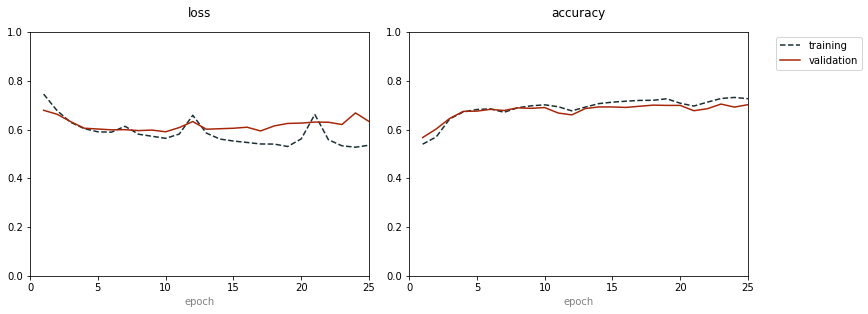







100%|██████████| 10/10 [33:45<00:00, 202.54s/it]


In [71]:
# and run the experiment
t = talos.Scan(x=X_TRAIN,
               y=Y_LABELS,
               model=pred_model,
               params=p,
               experiment_name='image_triplet',
               val_split=0.2,
               seed=0,
               print_params=True,
               round_limit=10)

In [73]:
t.data.head()

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,kernel_initializer,last_activation,losses,optimizer
0,25,0.255273,0.889173,0.508696,0.790402,relu,32,0.3,25,128,0,uniform,sigmoid,binary_crossentropy,Adam
1,50,0.425158,0.790773,0.713725,0.726347,elu,256,0.0,50,64,2,normal,relu,binary_crossentropy,Nadam
2,50,0.585634,0.708486,0.612662,0.695789,elu,64,0.3,50,64,2,uniform,relu,binary_crossentropy,Adam
3,25,0.494960,0.745184,0.547259,0.716476,elu,64,0.3,25,128,2,uniform,sigmoid,binary_crossentropy,Nadam
4,50,0.629007,0.675231,0.612268,0.683398,elu,64,0.5,50,64,1,uniform,relu,binary_crossentropy,Adam
